**Outline of Steps**
    + Initialization
        + Download VOC data from http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
        + Download pre-trained weights from http://pjreddie.com/media/files/tiny-yolo-voc.weights
        + Specify the directory of annotations by setting variable *ann_di*
        + Specify the directory of images by setting variable *img_dir*
        + Specity the path of pre-trained weights by setting variable *wt_path*
    + Construct equivalent network in Keras
        + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/tiny-yolo-voc.cfg
    + Load the pretrained weights
    + Preprocess VOC data
    + Perform training (for POC, the weights of the last layers are randomized before training)
    + Perform detection on an image with newly trained weights

## Initialization

In [1]:
from keras.models import Sequential
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
wt_path = 'tiny-yolo-voc.weights'                       
ann_dir = '/home/husky/data/pascal/VOCdevkit/VOC2012/Annotations/'
img_dir = '/home/husky/data/pascal/VOCdevkit/VOC2012/JPEGImages/'

In [3]:
execfile('utils.py')

LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
COLORS = [(43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),(194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),(224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(255,80,5)]

NORM_H, NORM_W = 416, 416
GRID_H, GRID_W = 13 , 13
BATCH_SIZE = 8
BOX = 5
CLASS = 20
THRESHOLD = 0.2
ANCHORS = '1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52'
ANCHORS = [float(ANCHORS.strip()) for ANCHORS in ANCHORS.split(',')]
SCALE_NOOB, SCALE_CONF, SCALE_COOR, SCALE_PROB = 0.5, 5.0, 5.0, 1.0
weight_reader = WeightReader(wt_path)

## Construct the network

In [4]:
model = Sequential()

# Layer 1
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(416,416,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2 - 5
for i in range(0,4):
    model.add(Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

# Layer 7 - 8
for _ in range(0,2):
    model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

# Layer 9
model.add(Conv2D(125, (1,1), strides=(1,1)))
model.add(Activation('linear'))
model.add(Reshape((13, 13, 5, 25)))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 208, 208, 32)      0         
__________

## Load pretrained weights

In [6]:
weight_reader.reset()

for i in range(len(model.layers)):
    if 'conv' in model.layers[i].name:
        if 'batch' in model.layers[i+1].name:
            norm_layer = model.layers[i+1]
            size = np.prod(norm_layer.get_weights()[0].shape)
            
            beta  = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean  = weight_reader.read_bytes(size)
            var   = weight_reader.read_bytes(size)
            
            weights = norm_layer.set_weights([gamma, beta, mean, var])
            
        conv_layer = model.layers[i]
        if len(conv_layer.get_weights()) > 1:
            bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel, bias])
        else:
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel])

## Preprocess VOC data

In [8]:
all_img = parse_annotation(ann_dir)

## Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [9]:
def custom_loss(y_true, y_pred):
    ### Adjust prediction
    # adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
    
    # adjust w and h
    pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
    
    # adjust probability
    pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
    
    y_pred = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_prob], 4)
    
    ### Adjust ground truth
    # adjust x and y
    center_xy = .5*(y_true[:,:,:,:,0:2] + y_true[:,:,:,:,2:4])
    center_xy = center_xy / np.reshape([(float(NORM_W)/GRID_W), (float(NORM_H)/GRID_H)], [1,1,1,1,2])
    true_box_xy = center_xy - tf.floor(center_xy)
    
    # adjust w and h
    true_box_wh = (y_true[:,:,:,:,2:4] - y_true[:,:,:,:,0:2])
    true_box_wh = tf.sqrt(true_box_wh / np.reshape([float(NORM_W), float(NORM_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
    pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
    pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
    
    true_tem_wh = tf.pow(true_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    true_box_area = true_tem_wh[:,:,:,:,0] * true_tem_wh[:,:,:,:,1]
    true_box_ul = true_box_xy - 0.5 * true_tem_wh
    true_box_bd = true_box_xy + 0.5 * true_tem_wh
    
    intersect_ul = tf.maximum(pred_box_ul, true_box_ul) 
    intersect_br = tf.minimum(pred_box_bd, true_box_bd)
    intersect_wh = intersect_br - intersect_ul
    intersect_wh = tf.maximum(intersect_wh, 0.0)
    intersect_area = intersect_wh[:,:,:,:,0] * intersect_wh[:,:,:,:,1]
    
    iou = tf.truediv(intersect_area, true_box_area + pred_box_area - intersect_area)
    best_box = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box = tf.to_float(best_box)
    true_box_conf = tf.expand_dims(best_box * y_true[:,:,:,:,4], -1)
    
    # adjust confidence
    true_box_prob = y_true[:,:,:,:,5:]
    
    y_true = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_prob], 4)
    #y_true = tf.Print(y_true, [true_box_wh], message='DEBUG', summarize=30000)    
    
    ### Compute the weights
    weight_coor = tf.concat(4 * [true_box_conf], 4)
    weight_coor = SCALE_COOR * weight_coor
    
    weight_conf = SCALE_NOOB * (1. - true_box_conf) + SCALE_CONF * true_box_conf
    
    weight_prob = tf.concat(CLASS * [true_box_conf], 4) 
    weight_prob = SCALE_PROB * weight_prob 
    
    weight = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    
    ### Finalize the loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight
    loss = tf.reshape(loss, [-1, GRID_W*GRID_H*BOX*(4 + 1 + CLASS)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

**Randomize weights of the last layer**

In [10]:
layer = model.layers[-3] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

**Retrain the network**

In [14]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

In [20]:
tb_counter  = max([int(num) for num in os.listdir('../logs/')]) + 1
tensorboard = TensorBoard(log_dir='../logs/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

sgd = SGD(lr=0.00001, decay=0.0005, momentum=0.9)

model.compile(loss=custom_loss, optimizer=sgd)#'adagrad')
model.fit_generator(data_gen(all_img, BATCH_SIZE), 
                    int(len(all_img)/BATCH_SIZE), 
                    epochs = 100, 
                    verbose = 2,
                    callbacks = [early_stop, checkpoint, tensorboard], 
                    max_q_size = 3)

Epoch 1/100
Epoch 00000: loss improved from 3.93289 to 3.83809, saving model to weights.hdf5
750s - loss: 3.8381
Epoch 2/100
Epoch 00001: loss did not improve
501s - loss: 3.8917
Epoch 3/100
Epoch 00002: loss did not improve
501s - loss: 3.8833
Epoch 4/100
Epoch 00003: loss did not improve
501s - loss: 3.8898
Epoch 5/100
Epoch 00004: loss improved from 3.83809 to 3.80191, saving model to weights.hdf5
502s - loss: 3.8019
Epoch 6/100
Epoch 00005: loss did not improve
501s - loss: 3.9354
Epoch 7/100
Epoch 00006: loss did not improve
501s - loss: 3.8326
Epoch 8/100
Epoch 00007: loss did not improve
501s - loss: 3.8934
Epoch 9/100
Epoch 00008: loss did not improve
501s - loss: 3.8808
Epoch 00008: early stopping


## Perform detection on image

In [23]:
model.load_weights("weights.hdf5")

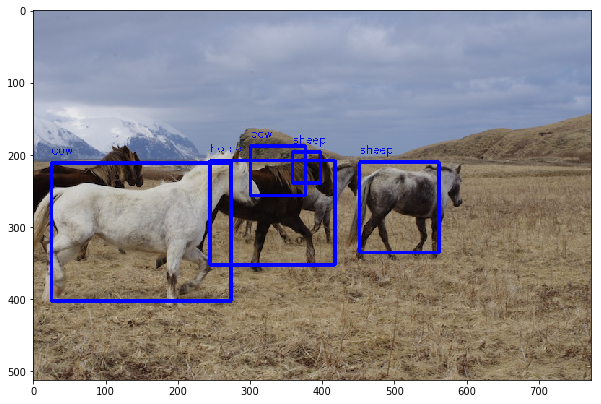

In [25]:
image = cv2.imread('images/horses.jpg')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict(input_image)

#print netout
image = interp_netout(image, netout[0])
plt.imshow(image[:,:,::-1]); plt.show()

## Perform detection on video

In [24]:
model.load_weights("weights.hdf5")

In [ ]:
video_inp = '../basic-yolo-keras/images/phnom_penh.mp4'
video_out = '../basic-yolo-keras/images/phnom_penh_bbox.mp4'

video_reader = cv2.VideoCapture(video_inp)
video_writer = None

while(True):
    ret, frame = video_reader.read()

    if ret == True:
        input_image = cv2.resize(frame, (416, 416))
        input_image = input_image / 255.
        input_image = input_image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)

        netout = model.predict(input_image)

        frame = interpret_netout(frame, netout[0])
        
        if video_writer is None:
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            video_writer = cv2.VideoWriter(video_out, fourcc, 50.0, (frame.shape[1], frame.shape[0]))
            
        video_writer.write(np.uint8(frame))
        
    else:
        break

video_reader.release()
video_writer.release()